# LSTM on Amazon Food Reviews

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

Attribute Information:

1.  index
2.  Id
3.  ProductId - unique identifier for the product
4.  UserId - unqiue identifier for the user
5.  ProfileName
6.  HelpfulnessNumerator - number of users who found the review helpful
7.  HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
8.  Score - rating between 1 and 5
9.  Time - timestamp for the review
10. Summary - brief summary of the review
11. Text - text of the review
12. ProcessedText - Cleaned & Preprocessed Text of the review

**Objective: Given Amazon Food reviews, sample 10,000 reviews then perform following tasks:**<br>

**1. Construct vocabulary of all the words in reviews.** <br>
**2. Construct table which contains frequency of each word in all the reviews.**<br>
**3. Sort the frequency table in descending order then assign index to each word. Top words will get index 1, second word will get index 2 and so on.**<br>
**4. Replace every word in all the reviews with its corresponding index which you have created in step 3.**<br>
**5. Apply padding to each review and make length of each review to 800.**<br>
**6. Split train and test data in a ratio of 80:20 then apply two layer LSTM and predict the polarity of each review in test data. Finally report test accuracy.**<br>

[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

Loading the data

SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently. Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plot
from wordcloud import WordCloud
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.cross_validation import train_test_split

C:\Users\GauravP\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
connection = sqlite3.connect("FinalAmazonFoodReviewsDataset.sqlite")

In [3]:
data = pd.read_sql_query("SELECT * FROM Reviews", connection)

In [4]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut the pean...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,Positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...


In [5]:
data.shape

(364171, 12)

In [6]:
data["Score"].value_counts()

Positive    307061
Negative     57110
Name: Score, dtype: int64

In [7]:
def changing(score):
    if score == "Positive":
        return 1
    else:
        return 0

In [8]:
previousScoreFormat = data["Score"]
newScoreFormat = list(map(changing, previousScoreFormat))
data["Score"] = newScoreFormat

In [9]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut the pean...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,1,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...


In [10]:
#taking 10000 random samples
data_10000 = data.sample(n = 10000)

In [11]:
data_10000 = data_10000.sort_values("Time", axis=0, ascending=True)

In [12]:
print(data_10000.shape)
print(data_10000["Score"].value_counts())

(10000, 12)
1    8440
0    1560
Name: Score, dtype: int64


In [13]:
data_10000.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
97414,138000,149768,B00004S1C5,A7P76IGRZZBFJ,"E. Thompson ""Soooooper Genius""",18,18,1,975974400,Who Needs Wilton?,I'm sick of scads of nasty toothpicks all over...,sick scad nasti toothpick all over counter whe...
308584,443667,479728,B00005U2FA,AR5RRP9N2UXDJ,"Boraxo ""Boraxo""",21,23,1,1029196800,It really works,"I was very skeptical when I bought this item, ...",was veri skeptic when bought this item imagin ...
231201,333923,361310,B00005IX96,A3DPP97CNG990R,"""websurpher""",12,12,1,1046044800,"Outstanding flavor, great price!",After years of using Starbuck's decaf and regu...,after year use starbuck decaf and regular sing...
227432,325019,351770,B0000DG4B3,A1IU7S4HCK1XK0,Joanna Daneman,13,15,1,1072656000,If they must have mac and cheese like the box ...,This is the powdered dried cheese like in &quo...,this the powder dri chees like canadian friend...
347510,502441,543222,B0000D17HA,A2B7BUH8834Y6M,"Shelley Gammon ""Geek""",4,4,1,1073174400,great noodles - sort of,Looking for a way to live up chicken noodle so...,look for way live chicken noodl soup lieu tini...


In [14]:
data_10000_labels = data_10000["Score"]

In [15]:
data_10000_labels.shape

(10000,)

## 1. Construct vocabulary of all the words in reviews. 

In [16]:
bowInitializer = CountVectorizer()
BoW = bowInitializer.fit_transform(data_10000["ProcessedText"].values)

In [17]:
print(BoW.shape); print(type(BoW))

(10000, 13095)
<class 'scipy.sparse.csr.csr_matrix'>


In [18]:
BoW_features = bowInitializer.get_feature_names()
len(BoW_features), type(BoW_features)

(13095, list)

## 2. Construct table which contains frequency of each word in all the reviews.

In [19]:
count = []
for i in range(len(BoW_features)):
    total = BoW.getcol(i).sum() # it will give sum of all the values in 'i'th column 
    count.append(total)

In [20]:
FrequencyTable = dict(zip(BoW_features, count))

## 3. Sort the frequency table in descending order then assign index to each word. Top words will get index 1, second word will get index 2 and so on.

In [21]:
FrequencyTable_sorted = sorted(FrequencyTable.items(), key = lambda FrequencyTable:FrequencyTable[1], reverse = True)

In [22]:
#printing first 200 elements of frequency table
for i in range(200):
    print(FrequencyTable_sorted[i])

('the', 31485)
('and', 22298)
('this', 11996)
('for', 9473)
('that', 7564)
('have', 6157)
('with', 6129)
('but', 6070)
('you', 5819)
('not', 5480)
('was', 5375)
('are', 5163)
('they', 4770)
('like', 4538)
('tast', 4488)
('these', 3981)
('flavor', 3544)
('good', 3526)
('them', 3478)
('one', 3320)
('product', 3303)
('use', 3197)
('love', 3153)
('great', 3089)
('it', 3036)
('veri', 2951)
('just', 2918)
('can', 2851)
('tri', 2795)
('from', 2622)
('tea', 2619)
('all', 2601)
('coffe', 2569)
('get', 2354)
('has', 2323)
('when', 2322)
('will', 2304)
('make', 2282)
('more', 2260)
('had', 2256)
('other', 2192)
('would', 2021)
('food', 2010)
('out', 2003)
('than', 1926)
('some', 1885)
('your', 1833)
('buy', 1832)
('time', 1753)
('amazon', 1745)
('eat', 1715)
('about', 1699)
('onli', 1695)
('order', 1646)
('realli', 1635)
('too', 1617)
('price', 1578)
('dont', 1550)
('also', 1545)
('were', 1543)
('find', 1531)
('much', 1492)
('what', 1477)
('best', 1461)
('there', 1443)
('littl', 1385)
('becaus', 

In [23]:
def PlotWordCloud(frequency):
    worcloudPlot = WordCloud(background_color="white", width=1500, height=1000)
    worcloudPlot.generate_from_frequencies(frequencies=frequency)
    plot.figure(figsize=(15,10))
    plot.imshow(worcloudPlot, interpolation="bilinear")
    plot.axis("off")
    plot.show()

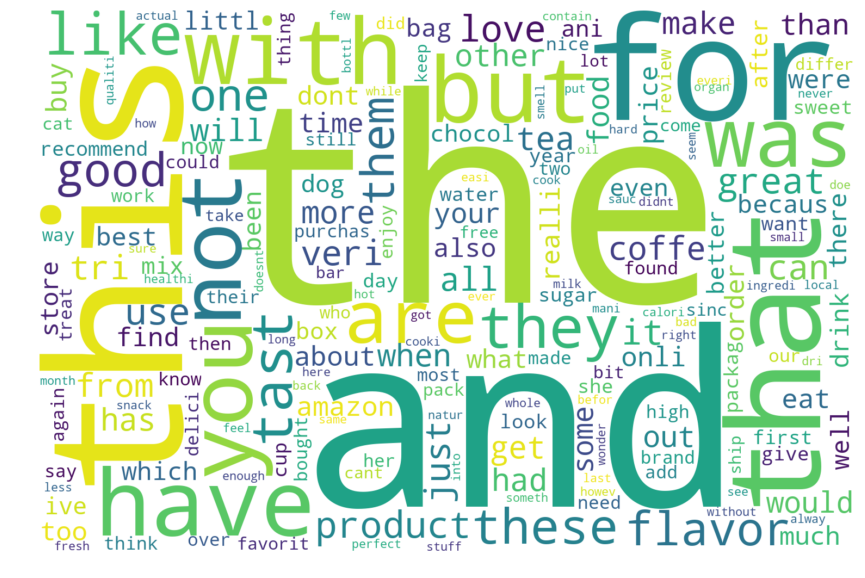

In [24]:
PlotWordCloud(FrequencyTable)

In [25]:
FrequencyTable_sorted_dict = dict(FrequencyTable_sorted)

In [26]:
#replacing each word with its index
count = 0
for key, value in FrequencyTable_sorted_dict.items():
    count += 1
    FrequencyTable_sorted_dict[key] = count

In [27]:
#printing first 200 word index
count = 0
for pairs in FrequencyTable_sorted_dict.items():
    if count < 200:
        print(pairs)
        count += 1

('the', 1)
('and', 2)
('this', 3)
('for', 4)
('that', 5)
('have', 6)
('with', 7)
('but', 8)
('you', 9)
('not', 10)
('was', 11)
('are', 12)
('they', 13)
('like', 14)
('tast', 15)
('these', 16)
('flavor', 17)
('good', 18)
('them', 19)
('one', 20)
('product', 21)
('use', 22)
('love', 23)
('great', 24)
('it', 25)
('veri', 26)
('just', 27)
('can', 28)
('tri', 29)
('from', 30)
('tea', 31)
('all', 32)
('coffe', 33)
('get', 34)
('has', 35)
('when', 36)
('will', 37)
('make', 38)
('more', 39)
('had', 40)
('other', 41)
('would', 42)
('food', 43)
('out', 44)
('than', 45)
('some', 46)
('your', 47)
('buy', 48)
('time', 49)
('amazon', 50)
('eat', 51)
('about', 52)
('onli', 53)
('order', 54)
('realli', 55)
('too', 56)
('price', 57)
('dont', 58)
('also', 59)
('were', 60)
('find', 61)
('much', 62)
('what', 63)
('best', 64)
('there', 65)
('littl', 66)
('becaus', 67)
('bag', 68)
('which', 69)
('well', 70)
('drink', 71)
('store', 72)
('been', 73)
('even', 74)
('dog', 75)
('ive', 76)
('after', 77)
('mix', 7

## 4. Replace every word in all the reviews with its corresponding index which you have created in step 3.

In [28]:
indexedReviews = []
for sentence in data_10000["ProcessedText"].values:
    filteredSentence = []
    for word in sentence.split():
        indx = FrequencyTable_sorted_dict[word]
        filteredSentence.append(indx)             
    indexedReviews.append(filteredSentence)

In [29]:
#printing first reviews
print(indexedReviews[0])
print(len(indexedReviews[0]))
print(type(indexedReviews[0]))

[892, 11844, 1009, 4132, 32, 109, 1593, 36, 7566, 1, 2162, 20, 5, 199, 11045, 2, 554, 2346, 1, 392, 12, 3355, 10, 6, 3107, 15, 2, 276, 730, 39, 346, 45, 1, 5157, 434, 502, 116, 473, 127, 34, 4355, 178, 94, 8, 25, 70, 295]
47
<class 'list'>


In [37]:
#checking any review whose length is greater than 800
count = 0
for i in indexedReviews:
    count += 1
    if len(i) > 800:
        print(count)

5871
7652


## 5. Apply padding to each review and make length of each review to 800.

In [38]:
max_review_length = 800
allReviews = sequence.pad_sequences(indexedReviews, maxlen=max_review_length)

In [39]:
print(allReviews.shape)
print(type(allReviews))
print(allReviews[0])

(10000, 800)
<class 'numpy.ndarray'>
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0  

## 6. Split train and test data in a ratio of 80:20 then apply two layer LSTM and predict the polarity of each review in test data. Finally report test accuracy.

In [40]:
#splitting the data in ratio of 80:20
train = allReviews[:8000]
train_labels = data_10000_labels[:8000]
test = allReviews[8000:10000]
test_labels = data_10000_labels[8000:10000]

In [41]:
train.shape, train_labels.shape, test.shape, test_labels.shape

((8000, 800), (8000,), (2000, 800), (2000,))

In [43]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(len(BoW_features) + 1, embedding_vecor_length, input_length=max_review_length)) #here "len(BoW_features) + 1"
#here, above we have added '1' because the "len(BoW_features)" include numbers only up till 13094. It does not include 13095 as
#it starts its numbering from 0. And in our vocabulary corpus, we have a word whose index is 13095, so when embedding process 
#that word where index is 13095, then key-error will occur, so that's why I have added 1. Nownumbering will be from 0 to 13095.
#It also includes 13095 now.
model.add(LSTM(64, return_sequences=True)) #here, "return sequence = True", means we need the sequence because we need to apply
#further LSTM where we want to pass this sequence, so we don't need the predicted output to be returned. We need the sequence 
#the sequenced output for further LSTM for processing.
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(train, train_labels, epochs=3, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 800, 32)           419072    
_________________________________________________________________
lstm_3 (LSTM)                (None, 800, 64)           24832     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 456,353
Trainable params: 456,353
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
8000/8000 [==============================] - 150s 19ms/step - loss: 0.3898 - acc: 0.8538
Epoch 2/3
8000/8000 [==============================] - 146s 18ms/step - loss: 0.2010 - acc: 0.9207
Epoch 3/3
8000/8000 [==============================] - 194s 24ms/

In [44]:
# embedding_1 (Embedding): 13096*32 = 419072
# lstm_1 (LSTM): # Formulae for Param = 4(n*m + n^2 + n) = 4(64*32 + 64*64 + 64(bias)) = 24832
# lstm_2 (LSTM): # Formulae for Param = 4(n*m + n^2 + n) = 4(32*64 + 32*32 + 32(bias)) = 12416
# dense_1 (Dense): # 32 outputs from 32 LSTM units and one bias. Total = 32+1 = 33

In [45]:
# Final evaluation of the model
predictions = model.predict(test)

In [46]:
predictClass = []
for i in predictions:
    if i > 0.5:
        predictClass.append(1)
    else:
        predictClass.append(0)

In [47]:
acc = accuracy_score(test_labels, predictClass)

In [48]:
print("Accuracy on test Data = "+str(acc*100)+"%")

Accuracy on test Data = 89.1%


In [49]:
print("Confusion Matrix")
print(confusion_matrix(test_labels, predictClass))

Confusion Matrix
[[ 197  153]
 [  65 1585]]


In [50]:
tn, fp, fn, tp = confusion_matrix(test_labels, predictClass).ravel()
(tn, fp, fn, tp)

(197, 153, 65, 1585)

In [53]:
print("AUC Value = "+str(roc_auc_score(test_labels, predictions)))

AUC Value = 0.9192536796536797
